Successfully generated 2185 hourly data points for load profile.

Total data points: 2185 hours
Training data size: 2179 hours (up to 2025-05-30 18:00:00)
Forecast period: 6 hours (from 2025-05-30 19:00:00 to 2025-05-31 00:00:00)

--- SARIMA Model (Single 6-hour Forecast) ---
Fitting SARIMA model with non-seasonal order (1, 1, 1) and seasonal order (1, 1, 0, 24)...
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2179
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 24)   Log Likelihood               -6200.700
Date:                             Tue, 03 Jun 2025   AIC                          12409.400
Time:                                     11:57:41   BIC                          12432.054
Sample:                                 03-01-2025   HQIC                         12417.692
                                      - 05-30-2025                              

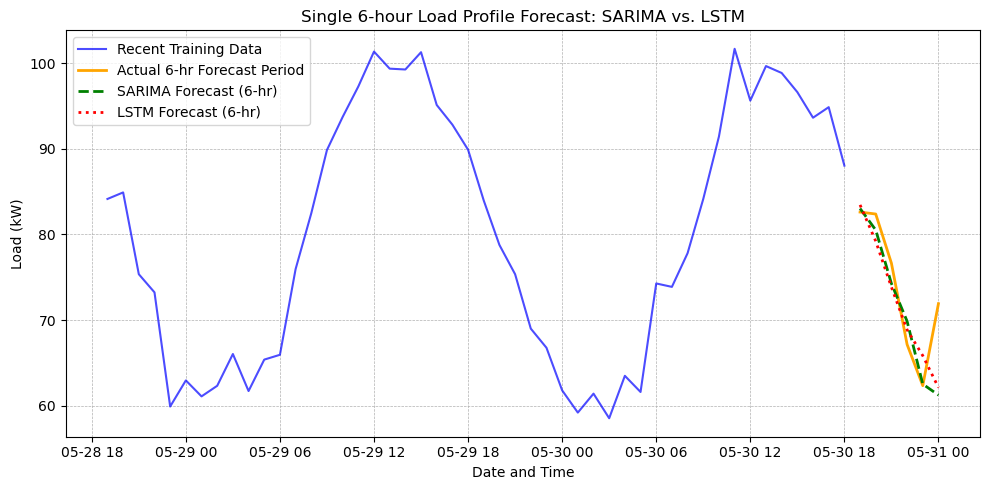


--- Summary of Performance for Single 6-hour Forecast ---
SARIMA: RMSE = 4.67, MAE = 3.04
LSTM:   RMSE = 4.65, MAE = 3.64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings

# Suppress harmless warnings
warnings.filterwarnings("ignore")

# --- 1. Generate Synthetic Hourly Load Profile Data ---
start_date = '2025-03-01'
end_date = '2025-05-31' # 3 months of hourly data
freq = 'H' # Hourly frequency

dates = pd.date_range(start=start_date, end=end_date, freq=freq)
n_points = len(dates)

base_load = 50
hour_of_day = dates.hour.to_numpy()
daily_pattern = (np.sin((hour_of_day - 8) * np.pi / 12) + 1) * 20

day_of_week = dates.dayofweek.to_numpy()
weekly_pattern = np.where(day_of_week < 5, 0, 10)

trend = np.linspace(0, 10, n_points)
noise = np.random.normal(0, 3, n_points)

load = np.array(base_load + daily_pattern + weekly_pattern + trend + noise)
load[load < 0] = 0

load_profile = pd.Series(load, index=dates)

print(f"Successfully generated {len(load_profile)} hourly data points for load profile.")

# --- 2. Visualize the Synthetic Data (Optional, already shown in previous steps) ---
# Omitted for brevity in this response

# --- 3. Prepare Data for Modeling (SARIMA & LSTM) ---
# For a single 6-hour forecast, we need to adjust the test_data definition.
# Let's define the training size and then the specific 6-hour forecast window.

# Keep a substantial training period, e.g., all but the last 24 hours of total data
# This leaves room for the 6-hour forecast window right after training.
TOTAL_DATA_POINTS = len(load_profile) # Total number of hours in synthetic data
FORECAST_HORIZON = 6 # We want to forecast exactly 6 hours
LOOK_BACK_FOR_TEST_DATA = 24 # Make sure there's enough data for LSTM input just before forecast start

# Define the training data to end right before our 6-hour forecast begins
train_data_end_index = TOTAL_DATA_POINTS - FORECAST_HORIZON
train_data = load_profile[:train_data_end_index]

# Define the specific 6-hour period we want to forecast and evaluate against
forecast_start_index = train_data_end_index
forecast_end_index = train_data_end_index + FORECAST_HORIZON - 1
actual_forecast_period = load_profile[forecast_start_index : forecast_end_index + 1]

# This `test_data` will now contain only the actual values for the 6-hour forecast window
test_data = actual_forecast_period


print(f"\nTotal data points: {TOTAL_DATA_POINTS} hours")
print(f"Training data size: {len(train_data)} hours (up to {train_data.index[-1]})")
print(f"Forecast period: {FORECAST_HORIZON} hours (from {test_data.index[0]} to {test_data.index[-1]})")


# --- 4. SARIMA Model Training and Forecasting ---
print("\n--- SARIMA Model (Single 6-hour Forecast) ---")
order = (1, 1, 1)
seasonal_order = (1, 1, 0, 24) # Daily seasonality (24 hours)

print(f"Fitting SARIMA model with non-seasonal order {order} and seasonal order {seasonal_order}...")

sarima_model = SARIMAX(train_data,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarima_model_fit = sarima_model.fit(disp=False)
print(sarima_model_fit.summary())

# Generate SARIMA forecasts for ONLY the 6-hour period
sarima_predictions = sarima_model_fit.predict(start=forecast_start_index,
                                               end=forecast_end_index,
                                               dynamic=True) # dynamic=True for true multi-step from start
sarima_predictions.index = test_data.index # Assign the correct index for evaluation

# Evaluate SARIMA on the single 6-hour forecast
mse_sarima = mean_squared_error(test_data, sarima_predictions)
rmse_sarima = sqrt(mse_sarima)
mae_sarima = mean_absolute_error(test_data, sarima_predictions)
print(f'SARIMA MSE (6-hr forecast): {mse_sarima:.2f}')
print(f'SARIMA RMSE (6-hr forecast): {rmse_sarima:.2f}')
print(f'SARIMA MAE (6-hr forecast): {mae_sarima:.2f}')

# --- 5. LSTM Model Training and Forecasting ---
print("\n--- LSTM Model (Single 6-hour Forecast) ---")

# Scale the data for LSTM - entire original load_profile is scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_load = scaler.fit_transform(load_profile.values.reshape(-1, 1))

# Split scaled data according to the new train/forecast period
scaled_train_data = scaled_load[:train_data_end_index]
scaled_actual_forecast_period = scaled_load[forecast_start_index : forecast_end_index + 1]

# Function to create sequences for LSTM
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        seq_x = data[i:end_ix]
        seq_y = data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in = 24 # Use past 24 hours to predict
n_steps_out = FORECAST_HORIZON # Predict 6 hours ahead

# Prepare training data for LSTM
X_train_lstm, y_train_lstm = create_sequences(scaled_train_data, n_steps_in, n_steps_out)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
y_train_lstm = y_train_lstm.reshape(y_train_lstm.shape[0], y_train_lstm.shape[1])

print(f"LSTM training input shape: {X_train_lstm.shape}")
print(f"LSTM training output shape: {y_train_lstm.shape}")

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, 1)))
lstm_model.add(Dense(n_steps_out))
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
print("Training LSTM model...")
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=75, batch_size=32, verbose=0)
print("LSTM model trained.")

# Generate LSTM forecasts for ONLY the 6-hour period
# The input for this single prediction is the last n_steps_in from the training data
single_forecast_input = scaled_train_data[-n_steps_in:].reshape(1, n_steps_in, 1)

# Get the single 6-hour prediction
lstm_predictions_scaled_raw = lstm_model.predict(single_forecast_input, verbose=0)[0] # Get the first (and only) prediction

# Inverse transform the predictions to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled_raw.reshape(-1, 1))
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test_data.index) # Assign the correct index
lstm_predictions[lstm_predictions < 0] = 0 # Ensure no negative predictions

# Evaluate LSTM on the single 6-hour forecast
mse_lstm = mean_squared_error(test_data, lstm_predictions)
rmse_lstm = sqrt(mse_lstm)
mae_lstm = mean_absolute_error(test_data, lstm_predictions)
print(f'LSTM MSE (6-hr forecast): {mse_lstm:.2f}')
print(f'LSTM RMSE (6-hr forecast): {rmse_lstm:.2f}')
print(f'LSTM MAE (6-hr forecast): {mae_lstm:.2f}')

# --- 6. Comparative Visualization of the SINGLE 6-hour Forecast ---

plt.figure(figsize=(10, 5)) # Adjust figure size for single forecast view
# Plot only the relevant portion of training data just before the forecast
plot_train_data = train_data.tail(n_steps_in * 2) # Show last 2 * n_steps_in hours of training

plt.plot(plot_train_data.index, plot_train_data, label='Recent Training Data', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data, label='Actual 6-hr Forecast Period', color='orange', linewidth=2)
plt.plot(sarima_predictions.index, sarima_predictions, label=f'SARIMA Forecast ({FORECAST_HORIZON}-hr)', color='green', linestyle='--', linewidth=2)
plt.plot(lstm_predictions.index, lstm_predictions, label=f'LSTM Forecast ({FORECAST_HORIZON}-hr)', color='red', linestyle=':', linewidth=2)

plt.title(f'Single {FORECAST_HORIZON}-hour Load Profile Forecast: SARIMA vs. LSTM')
plt.xlabel('Date and Time')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\n--- Summary of Performance for Single 6-hour Forecast ---")
print(f"SARIMA: RMSE = {rmse_sarima:.2f}, MAE = {mae_sarima:.2f}")
print(f"LSTM:   RMSE = {rmse_lstm:.2f}, MAE = {mae_lstm:.2f}")